In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython){
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Exploration

In [3]:
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
# data exploration - looking for empty values
data.count().unique()

array([299])

### Preprocessing

### Simple models

In [5]:
import sklearn
from tqdm.auto import tqdm
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [6]:
X = data.drop(['DEATH_EVENT'],axis=1)
y = data['DEATH_EVENT']

In [7]:
# multiple train-and-test with DT to evaluates model robustness
# 100 iterations
# all features used
# 66/34 holdout

clf = tree.DecisionTreeClassifier()
accuracy_values = []
for i in tqdm(range(100)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.66, test_size=0.34)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_values.append(metrics.accuracy_score(y_test, y_pred))

accuracy_values = np.array(accuracy_values)
print(f'accuracy mean: {accuracy_values.mean():.2f}')
print(f'accuracy std:  {accuracy_values.std():.2f}')

  0%|          | 0/100 [00:00<?, ?it/s]

accuracy mean: 0.77
accuracy std:  0.04


In [8]:
# multiple train-and-test with DT to evaluates model robustness
# 100 iterations
# a bit of feature selection
# 66/34 holdout

features = ['age','anaemia','sex','smoking']
clf = tree.DecisionTreeClassifier()
accuracy_values = []
for i in tqdm(range(100)):
    X_train, X_test, y_train, y_test = train_test_split(X[features], y, train_size=0.66, test_size=0.34)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_values.append(metrics.accuracy_score(y_test, y_pred))

accuracy_values = np.array(accuracy_values)
print(f'accuracy mean: {accuracy_values.mean():.2f}')
print(f'accuracy std:  {accuracy_values.std():.2f}')

  0%|          | 0/100 [00:00<?, ?it/s]

accuracy mean: 0.64
accuracy std:  0.04


In [9]:
# actually a silly idea: using predictions ad features
# adding up to 10 new features
# 100 iterations
# a bit of feature selection
# 66/34 holdout

features = ['age','anaemia','sex','smoking']
clf = tree.DecisionTreeClassifier()
accuracy_values = []

for i in tqdm(range(100)):
    X_train, X_test, y_train, y_test = train_test_split(X[features], y, train_size=0.66, test_size=0.34)
    for j in range(20):
        clf.fit(X_train, y_train)
        X_train[f'pred_{j}'] = clf.predict(X_train)==y_train
        X_test[f'pred_{j}'] = clf.predict(X_test)==y_test
    y_pred = clf.predict(X_test.drop([f'pred_{j}'],axis=1))
    accuracy_values.append(metrics.accuracy_score(y_test, y_pred))
    
accuracy_values = np.array(accuracy_values)
print(f'accuracy mean: {accuracy_values.mean():.2f}')
print(f'accuracy std:  {accuracy_values.std():.2f}')

  0%|          | 0/100 [00:00<?, ?it/s]

accuracy mean: 0.86
accuracy std:  0.04


In [10]:
# actually a silly idea: using predictions ad features
# adding up to 50 new features
# 100 iterations
# a bit of feature selection
# 66/34 holdout

features = ['age','anaemia','sex','smoking']
clf = tree.DecisionTreeClassifier()
accuracy_values = []

for i in tqdm(range(20)):
    X_train, X_test, y_train, y_test = train_test_split(X[features], y, train_size=0.66, test_size=0.34)
    this_accuracy = []
    for j in range(50):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        this_accuracy.append(np.array(metrics.accuracy_score(y_test, y_pred)).mean())
        X_train[f'pred_{j}'] = clf.predict(X_train)==y_train
        X_test[f'pred_{j}'] = clf.predict(X_test)==y_test
    accuracy_values.append(this_accuracy)

  0%|          | 0/20 [00:00<?, ?it/s]

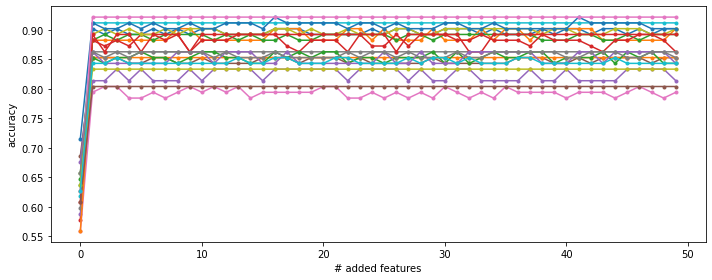

In [11]:
fig,ax = plt.subplots(figsize=(10,4))

for value in accuracy_values:
    ax.plot(np.arange(len(value)),value,'.-')
    ax.set_xlabel('# added features')
    ax.set_ylabel('accuracy')

fig.tight_layout()

In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[57, 14],
       [ 2, 29]])

### Oversampling

In [13]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_over, y_over = oversample.fit_resample(X, y)

In [14]:
X_over.sample(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
403,83.399923,0,582,0,36,0,263358.03,1.83,134,0,0,77
101,75.000000,0,582,0,45,1,263358.03,1.18,137,1,0,87
200,63.000000,1,1767,0,45,0,73000.00,0.70,137,1,0,186
230,60.000000,0,166,0,30,0,62000.00,1.70,127,0,0,207
34,65.000000,0,94,1,50,1,188000.00,1.00,140,1,0,29


In [15]:
# actually a silly idea: using predictions ad features
# adding up to 50 new features
# 100 iterations
# a bit of feature selection
# 66/34 holdout

features = ['age','anaemia','sex','smoking']
clf = tree.DecisionTreeClassifier()
accuracy_values = []

for i in tqdm(range(20)):
    X_train, X_test, y_train, y_test = train_test_split(X_over[features], y_over, train_size=0.66, test_size=0.34)
    this_accuracy = []
    for j in range(50):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        this_accuracy.append(np.array(metrics.accuracy_score(y_test, y_pred)).mean())
        X_train[f'pred_{j}'] = clf.predict(X_train)==y_train
        X_test[f'pred_{j}'] = clf.predict(X_test)==y_test
    accuracy_values.append(this_accuracy)

  0%|          | 0/20 [00:00<?, ?it/s]

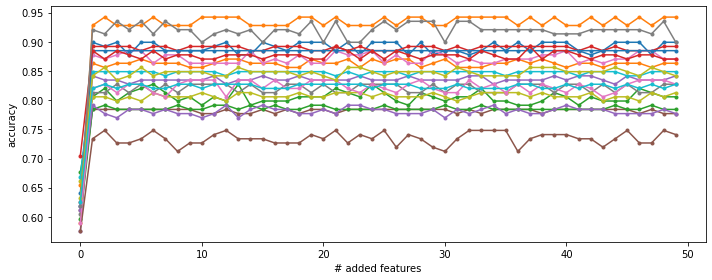

In [16]:
fig,ax = plt.subplots(figsize=(10,4))

for value in accuracy_values:
    ax.plot(np.arange(len(value)),value,'.-')
    ax.set_xlabel('# added features')
    ax.set_ylabel('accuracy')

fig.tight_layout()

In [17]:
results = y_test.to_frame().rename(columns={"DEATH_EVENT": "true_value"})
results['predicted'] = y_pred

In [18]:
confusion_matrix(results.query('index<299').true_value,results.query('index<299').predicted)

array([[57, 17],
       [ 4, 31]])

### Test zone

In [36]:
import seaborn as sns

class TreeTester():
    def __init__(self,*args,**kwargs):
        # Set default parameters
        self.features = None
        self.train_size = 0.66
        self.robustness_iterations = 100
        self.auto_train = False
        self.added_features = 0
        self.oversample = False
        self.data = pd.DataFrame()
        self.X_train = pd.DataFrame() 
        self.X_test = pd.DataFrame() 
        self.y_train = pd.DataFrame() 
        self.y_test = pd.DataFrame() 
        self.y_pred = pd.DataFrame() 
        self.target = ''
        self.classifier = tree.DecisionTreeClassifier()
        # Update with provided parameters
        self.__dict__.update(kwargs)
        # Actual initialization
        self.original_rows = len(self.data)
        self.X = self.data.drop([self.target],axis=1)
        self.y = self.data[self.target]
        self.evaluators = {}
        
        
    def train(self):
        # oversampling, if needed
        X = self.X
        y = self.y
        if self.oversample:
            oversample = SMOTE()
            X,y = oversample.fit_resample(X,y)
        # feature selection
        if self.features:
            X_train, X_test, y_train, y_test = train_test_split(X[features], y, train_size=self.train_size,
                                                                test_size=1-self.train_size)
        else:
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=self.train_size,
                                                                test_size=1-self.train_size)
        # using model's guess as a feature
        if self.auto_train:
            for j in range(self.added_features):
                self.classifier.fit(X_train, y_train)
                y_pred = self.classifier.predict(X_test)
                X_train[f'pred_{j}'] = self.classifier.predict(X_train)==y_train
                X_test[f'pred_{j}'] = self.classifier.predict(X_test)==y_test
        self.classifier.fit(X_train, y_train)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        
    def evaluate(self):
        accuracy = []
        recall = []
        precision = []
        F1_measure = []
        for i in range(self.robustness_iterations):
            self.train()
            results = self.y_test.to_frame().rename(columns={self.target: "true_value"})
            self.y_pred = self.classifier.predict(self.X_test)
            results['predicted'] = self.y_pred
            cm = confusion_matrix(results.query('index<@self.original_rows').true_value,results.query('index<@self.original_rows').predicted)
            TP = cm[0][0]
            FP = cm[0][1]
            FN = cm[1][0]
            TN = cm[1][1]
            accuracy.append((TP+TN)/(TP+TN+FP+FN))
            recall.append(TP/(TP+FN))
            precision.append(TP/(TP+FP))
            F1_measure.append(2*precision[-1]*recall[-1]/(precision[-1]+recall[-1]))
        self.evaluators['accuracy'] = accuracy
        self.evaluators['recall'] = recall
        self.evaluators['precision'] = precision
        self.evaluators['F1_measure'] = F1_measure
        self.evaluators = pd.DataFrame.from_dict(self.evaluators)
        
    
    def plot_results(self):
        fig,ax = plt.subplots()
        sns.boxplot(x="variable", y="value", data=pd.melt(self.evaluators))
        return

In [37]:
TT = TreeTester(data=data,target='DEATH_EVENT',)

In [38]:
TT.evaluate()

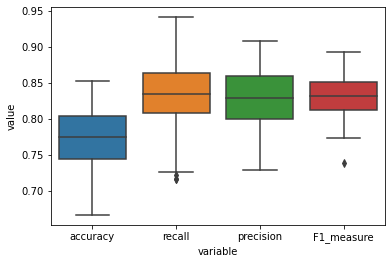

In [39]:
TT.plot_results()

In [22]:
pd.DataFrame.from_dict(TT.evaluators)

,accuracy,recall,precision,F1_measure
0,0.794118,0.869565,0.833333,0.851064
1,0.754902,0.814286,0.826087,0.820144
2,0.813725,0.898551,0.837838,0.867133
3,0.794118,0.842105,0.876712,0.859060
4,0.745098,0.825397,0.776119,0.800000
...,...,...,...,...
95,0.705882,0.833333,0.714286,0.769231
96,0.647059,0.707692,0.730159,0.718750
97,0.696078,0.810345,0.701493,0.752000
98,0.745098,0.873016,0.753425,0.808824


<AxesSubplot:xlabel='variable', ylabel='value'>

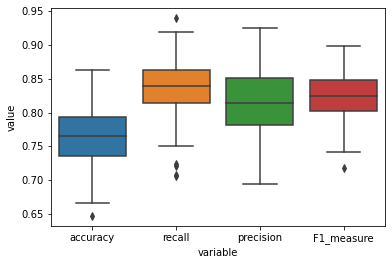

In [23]:
sns.boxplot(x="variable", y="value", data=pd.melt(pd.DataFrame.from_dict(TT.evaluators)))